## Helper Functions

In [1]:
import hashlib

In [2]:
def balanced_remainder(a, b):
    """
    Helper function to get a remainder in the range (-b/2, b/2]
    """
    a = a % b
    if a > b // 2:
        return a - b
    else:
        return a

print("done")

done


In [3]:
from random import sample

def extra_secure_poly_generator(d, N, small_modulo):
    """
    Generate key with larger range not just -1, 0 ,1
    """
    if 2*d >= N:
        raise ValueError("2*d must be less than N")
        
    coefficients = [0] * N
    positions = sample(range(N), 2*d)

    for i in range(d):
        coefficients[positions[i]] = ZZ.random_element(small_modulo-1)+1

    for i in range(d, 2*d):
        coefficients[positions[i]] = -(ZZ.random_element(small_modulo-1)+1)
        
    return vector(ZZ, coefficients)

print("done")

done


In [4]:
def rand_poly_generator(d, N):
    
    if 2*d >= N:
        raise ValueError("2*d must be less than N")

    coefficients = [0] * N
    positions = sample(range(N), 2*d)
    
    # Place d ones
    for i in range(d):
        coefficients[positions[i]] = 1
    
    # Place d minus-ones
    for i in range(d, 2*d):
        coefficients[positions[i]] = -1

    return vector(ZZ, coefficients)

print("done")

done


## Key Generation

In [5]:
def generate_keypair(small_modulo, big_modulo, N, d):
    """
    Generates an NTRU public and private key.
    """
    while True:
        f = extra_secure_poly_generator(d, N, small_modulo)
        f += vector(ZZ, [1] + [0]*(N-1))

        # Check for invertibility
        cir_f = matrix.circulant(f)
        cir_f_det = cir_f.determinant()

        if (cir_f_det.gcd(big_modulo) == 1) and (cir_f_det.gcd(small_modulo) == 1):
                break

    g = extra_secure_poly_generator(d, N, small_modulo)
    
    cir_f_bigmod = matrix.circulant(vector(Zmod(big_modulo),list(f)))
    cir_f_smallmod = matrix.circulant(vector(Zmod(small_modulo), list(f)))

    public_key = g*cir_f_bigmod^-1
    public_key = vector(ZZ,list(public_key))

    f_inv_vector = vector(Zmod(small_modulo), [1] + [0]*(N-1)) * cir_f_smallmod.inverse()
    private_key = (f,f_inv_vector)
    return private_key, public_key
    
print("done")

done


## Public Key Encryption (PKE)

In [6]:
def encrypt_PKE(message, public_key, small_modulus, big_modulus, N, d):
    """
    Encrypts message using public key
    """
    blinding_poly = rand_poly_generator(d, N)

    aux = small_modulus * blinding_poly * matrix.circulant(public_key)
    aux = vector([element.mod(big_modulus) for element in list(aux)])

    ciphertext = message + aux
    ciphertext = vector([element.mod(big_modulus) for element in list(ciphertext)])
    
    return ciphertext

print("done")

done


In [7]:
def decrypt_PKE(ciphertext, private_key, small_modulus, big_modulus, N):
    """
    Decrypts a ciphertext.
    """
    f, f_inv_vector = private_key
    
    aux = ciphertext * matrix.circulant(f)
    aux = vector([element.mod(big_modulus) for element in list(aux)])
    
    aux = vector([balanced_remainder(element, big_modulus) for element in list(aux)])
    
    aux = vector([element.mod(small_modulus) for element in list(aux)])
    aux = vector([balanced_remainder(element, small_modulus) for element in list(aux)])
    
    f_vector = matrix.circulant(f_inv_vector)
    message_recovered = aux * f_vector
    
    message_recovered = vector(ZZ, list(message_recovered))
    message_recovered = vector([balanced_remainder(element, small_modulus) for element in list(message_recovered)])
    
    return message_recovered

print("done")

done


## Key Encapsulation Mechanism (KEM)

In [8]:
def encapsulation_KEM(public_key, small_modulus, big_modulus, N, d):
    """
    Generate message inside the function and then encrypt
    """
    message = rand_poly_generator(d, N)
    ciphertext = encrypt_PKE(message, public_key, small_modulus, big_modulus, N, d)
    
    chain_poly = ''
    for i in range(N):
        chain_poly += Integer(message[i]).binary()
        
    shared_secret = Integer('0x' + hashlib.sha256(chain_poly.encode('utf-8')).hexdigest()).binary()
    
    # 4. Return the ciphertext and the hashed secret
    return ciphertext, shared_secret

print("done")

done


In [9]:
def decapsulation_KEM(ciphertext, private_key, small_modulus, big_modulus, N):
    
    message_recovered = decrypt_PKE(ciphertext, private_key, small_modulus, big_modulus, N)
    
    chain_m = ''
    for i in range(N):
        chain_m += Integer(message_recovered[i]).binary()
        
    shared_secret_hash = hashlib.sha256(chain_m.encode('utf-8')).hexdigest()
    shared_secret_binary = Integer('0x' + shared_secret_hash).binary()
    
    return shared_secret_binary

print("done")

done


## Check

In [10]:
def cross_check(decrypted_message, plain_text, N):
    """
    Checks if decryption was successful.
    """
    plain_coeffs = plain_text.list()
    plain_coeffs.extend([0] * (N - len(plain_coeffs)))
    
    dec_coeffs = decrypted_message.list()
    dec_coeffs.extend([0] * (N - len(dec_coeffs)))
    
    if plain_coeffs == dec_coeffs:
        print("✅ Successful!")
        return True
    else:
        print("❌ Error!!!")
        print(f"  Plaintext: {vector(plain_coeffs)}")
        print(f"  Decrypted: {vector(dec_coeffs)}")
        return False

## Testing

In [11]:
# Standard NTRU parameters (must be co-prime)
N = 11
p = 3
q = 64 # Must be a power of 2
d = N // 3 # d=3, so 3 ones and 3 minus-ones
print(f"--- NTRU Parameters ---")
print(f"N = {N} (dimension)")
print(f"p = {p} (small modulus)")
print(f"q = {q} (large modulus)")
print(f"d = {d} (key 'smallness')\n")

--- NTRU Parameters ---
N = 11 (dimension)
p = 3 (small modulus)
q = 64 (large modulus)
d = 3 (key 'smallness')



In [12]:
# 1. Key Generation
print("Generating keys...")
private_key, public_key = generate_keypair(p, q, N, d)
print(f"Public Key (h): {public_key}")
print(f"Secret Key (f): {private_key[0]}\n")
print(f"Secret Key (g): {private_key[1]}\n")

Generating keys...
Public Key (h): (49, 59, 57, 43, 26, 2, 22, 60, 16, 55, 60)
Secret Key (f): (0, 0, 1, 0, 1, 1, 0, 0, -2, -2, 0)

Secret Key (g): (1, 2, 2, 1, 2, 0, 1, 1, 1, 2, 1)



### Testing PKE

In [13]:
# 2. Encryption
print("Encrypting...")
message = rand_poly_generator(d, N)
ciphertext = encrypt_PKE(message, public_key, p, q, N, d)
print("Decrypting...")
decrypted_message = decrypt_PKE(ciphertext, private_key, p, q, N)
print(f"msg = {message} (dimension)")
print(f"dec_msg = {decrypted_message} (dimension)")

Encrypting...
Decrypting...
msg = (-1, 0, 0, -1, -1, 1, 0, 0, 0, 1, 1) (dimension)
dec_msg = (-1, 0, 0, -1, -1, 1, 0, 0, 0, 1, 1) (dimension)


In [14]:
# 4. Check
cross_check(decrypted_message, message, N)

✅ Successful!


True

### Testing KEM

In [15]:
print("Encapsulating...")
ciphertext, shared_secret_sent = encapsulation_KEM(public_key, p, q, N, d)
print("Decapsulating...")
shared_secret_received = decapsulation_KEM(ciphertext, private_key, p, q, N)

if (shared_secret_sent == shared_secret_received):
    print("✅ Successful!")
else:
    print("❌ Error!!!")

Encapsulating...
Decapsulating...
✅ Successful!


## LLL Attack

In [19]:
def construct_ntru_lattice_basis(public_key, N, big_modulus):
    """
    Constructs the 2N x 2N NTRU public lattice basis M_h.
    
    M_h = [ I_n  |  cir_pub_key ]
          [ 0_n  |  bigmod*I_n ]
    """

    cir_pub_key = matrix.circulant(public_key)
    I_n = matrix.identity(N)
    O_n = matrix.zero(N)
    bigmod_I_n = big_modulus * I_n

    M_h = block_matrix(ZZ, [
        [I_n, cir_pub_key],
        [O_n, bigmod_I_n]
    ])

    return M_h

print("done")

done


In [31]:
# Standard NTRU parameters (must be co-prime)
N = 11
p = 3
q = 64 # Must be a power of 2
d = N // 3 # d=3, so 3 ones and 3 minus-ones
print(f"--- NTRU Parameters ---")
print(f"N = {N} (dimension)")
print(f"p = {p} (small modulus)")
print(f"q = {q} (large modulus)")
print(f"d = {d} (key 'smallness')\n")

--- NTRU Parameters ---
N = 11 (dimension)
p = 3 (small modulus)
q = 64 (large modulus)
d = 3 (key 'smallness')



In [33]:
print("Generating keys...")
private_key, public_key = generate_keypair(p, q, N, d)

Generating keys...


In [34]:
print("Encrypting...")
message = rand_poly_generator(d, N)
ciphertext = encrypt_PKE(message, public_key, p, q, N, d)

Encrypting...


In [42]:
### Information available => ciphertext, public_key
attacker_message = run_attack_and_decrypt(ciphertext, public_key, p, q, N, d)

if attacker_message is not None:
    print("\n--- Attacker's FINAL RESULT ---")
    attack_success = cross_check(attacker_message, message, N)
    if attack_success:
        print("\n*** LLL ATTACK SUCCEEDED ***")
else:
    print("\n*** LLL ATTACK FAILED ***")

Constructing 2N x 2N lattic...
Performing LLL on 2Nx2N matrix
LLL Complete, extracting shortest vector...
Found f_attack = (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
computing f_p_inv...
Failed: f_attack not invertible: input matrix must be nonsingular

*** LLL ATTACK FAILED ***


In [17]:
def run_attack_and_decrypt(public_key, ciphertext, small_modulus, big_modulus, N, d):
    """
    Perform entire LLL attack
    """
    print("Constructing 2N x 2N lattic...")
    M_h = construct_ntru_lattice_basis(public_key, N, big_modulus)

    print("Performing LLL on 2Nx2N matrix")
    try:
        M_LLL = M_h.LLL(implementation="fplll")
    except:
        M_LLL = M_h.LLL()

    print("LLL Complete, extracting shortest vector...")
    b1 = M_LLL[0]

    f_attack = vector(ZZ, b1[0:N])

    if f_attack[0] == -1:
        f_attack = -f_attack

    print(f"Found f_attack = {f_attack}")

    print("computing f_p_inv...")
    try:
        cir_f_smallmod_attack = matrix.circulant(vector(Zmod(small_modulus), list(f_attack)))
        f_inv_vector_attack = vector(Zmod(small_modulus), [1] + [0]*(N-1)) * cir_f_smallmod_attack.inverse()

        attacker_private_key = (f_attack, f_inv_vector_attack)
        print("Successfully built attack key...")

        print("Attempting decryption...")
        decrypted_message = decrypt_PKE(ciphertext, attacker_private_key, small_modulus, big_modulus, N)
        return decrypted_message

    except Exception as e:
        print(f"Failed: f_attack not correct: {e}")
        return None

In [53]:
def run_test(p, q, N, d, limit, tries):
    success = 0
    failure = 0
    valid = 0
    for i in range(1, limit+1):
        for _ in range(tries):
            private_key, public_key = generate_keypair(p, q, N, d)
            message = rand_poly_generator(d, N)
            ciphertext = encrypt_PKE(message, public_key, p, q, N, d)
            attacker_message = run_attack_and_decrypt(ciphertext, public_key, p, q, N, d)
            decrypted_message = decrypt_PKE(ciphertext, private_key, p, q, N)
            if decrypted_message == message:
                valid+=1
            
            if attacker_message is not None:
                attack_success = cross_check(attacker_message, message, N)
                if attack_success:
                    success+=1
                else: failure+=1
            else:
                failure+=1
        q = q * 2^i

    return success, failure, valid

In [54]:
p=3
q=256
N=19
d=N//3
limit=3
tries=5
success, failure, valid = run_test(p,q,N,d,limit,tries)
print(f"success={success}")
print(f"failure={failure}")
print(f"valid={valid}")

Constructing 2N x 2N lattic...
Performing LLL on 2Nx2N matrix
LLL Complete, extracting shortest vector...
Found f_attack = (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
computing f_p_inv...
Failed: f_attack not invertible: input matrix must be nonsingular
Constructing 2N x 2N lattic...
Performing LLL on 2Nx2N matrix
LLL Complete, extracting shortest vector...
Found f_attack = (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
computing f_p_inv...
Failed: f_attack not invertible: input matrix must be nonsingular
Constructing 2N x 2N lattic...
Performing LLL on 2Nx2N matrix
LLL Complete, extracting shortest vector...
Found f_attack = (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
computing f_p_inv...
Failed: f_attack not invertible: input matrix must be nonsingular
Constructing 2N x 2N lattic...
Performing LLL on 2Nx2N matrix
LLL Complete, extracting shortest vector...
Found f_attack = (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
computing f_p_i

In [24]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib
from sage.all import *

# ==========================================
# 1. KEM WRAPPERS (To ensure we time the full process)
# ==========================================
def ntru_encapsulate(pub_key, p, q, N, d):
    """
    Generates a random message, encrypts it, and hashes it to form a shared key.
    Returns: (ciphertext, shared_secret_hash)
    """
    # 1. Generate random message (polynomial)
    r_msg = rand_poly_generator(d, N)
    
    # 2. Encrypt using PKE
    ciphertext = encrypt_PKE(r_msg, pub_key, p, q, N, d)
    
    # 3. Hash to get shared secret
    # Convert poly to string bytes for hashing
    secret_bytes = str(r_msg.list()).encode('utf-8')
    shared_secret = hashlib.sha256(secret_bytes).hexdigest()
    
    return ciphertext, shared_secret

def ntru_decapsulate(ciphertext, priv_key, p, q, N):
    """
    Decrypts the message and hashes it to recover the shared key.
    """
    # 1. Decrypt using PKE
    r_msg_dec = decrypt_PKE(ciphertext, priv_key, p, q, N)
    
    # 2. Hash
    secret_bytes = str(r_msg_dec.list()).encode('utf-8')
    shared_secret = hashlib.sha256(secret_bytes).hexdigest()
    
    return shared_secret

# ==========================================
# 2. TIMING EXPERIMENT (KeyGen, Encap, Decap)
# ==========================================
def run_ntru_kem_timing(N_list, q_fixed=2048, trials=10):
    results = []
    
    print(f"--- Benchmarking NTRU KEM Performance ---")
    print(f"N values: {N_list}")
    print(f"Fixed q:  {q_fixed}")
    
    for N_val in N_list:
        N = int(N_val) # Cast to python int
        d = int(N // 3)
        p = 3
        
        # Generator constraint check
        if 2*d >= N:
            continue
            
        print(f"Testing N={N}...", end=" ", flush=True)
        
        t_keygen_sum = 0
        t_encap_sum = 0
        t_decap_sum = 0
        valid_trials = 0
        
        for i in range(trials):
            try:
                # --- A. Time KeyGen ---
                t0 = time.time()
                priv, pub = generate_keypair(p, q_fixed, N, d)
                t_keygen_sum += (time.time() - t0)
                
                # --- B. Time Encapsulate ---
                t0 = time.time()
                ciphertext, secret_ss = ntru_encapsulate(pub, p, q_fixed, N, d)
                t_encap_sum += (time.time() - t0)
                
                # --- C. Time Decapsulate ---
                t0 = time.time()
                recovered_ss = ntru_decapsulate(ciphertext, priv, p, q_fixed, N)
                t_decap_sum += (time.time() - t0)
                
                valid_trials += 1
            except Exception as e:
                # Skip failed trials
                continue

        if valid_trials > 0:
            # Calculate Averages in MILLISECONDS (ms) for better readability
            avg_keygen = float((t_keygen_sum / valid_trials) * 1000)
            avg_encap = float((t_encap_sum / valid_trials) * 1000)
            avg_decap = float((t_decap_sum / valid_trials) * 1000)
            
            print(f"Done. (Encap: {avg_encap:.2f} ms)")
            
            results.append({
                'N': N,
                'KeyGen (ms)': avg_keygen,
                'Encapsulate (ms)': avg_encap,
                'Decapsulate (ms)': avg_decap
            })
        else:
            print("Failed all trials.")
            
    return pd.DataFrame(results)

--- Benchmarking NTRU KEM Performance ---
N values: [41, 53, 61, 83, 101, 137, 167, 191, 251]
Fixed q:  2048
Testing N=41... Done. (Encap: 1.10 ms)
Testing N=53... Done. (Encap: 1.23 ms)
Testing N=61... Done. (Encap: 1.57 ms)
Testing N=83... Done. (Encap: 2.98 ms)
Testing N=101... Done. (Encap: 3.47 ms)
Testing N=137... Done. (Encap: 5.55 ms)
Testing N=167... Done. (Encap: 9.30 ms)
Testing N=191... Done. (Encap: 12.68 ms)
Testing N=251... Done. (Encap: 22.96 ms)


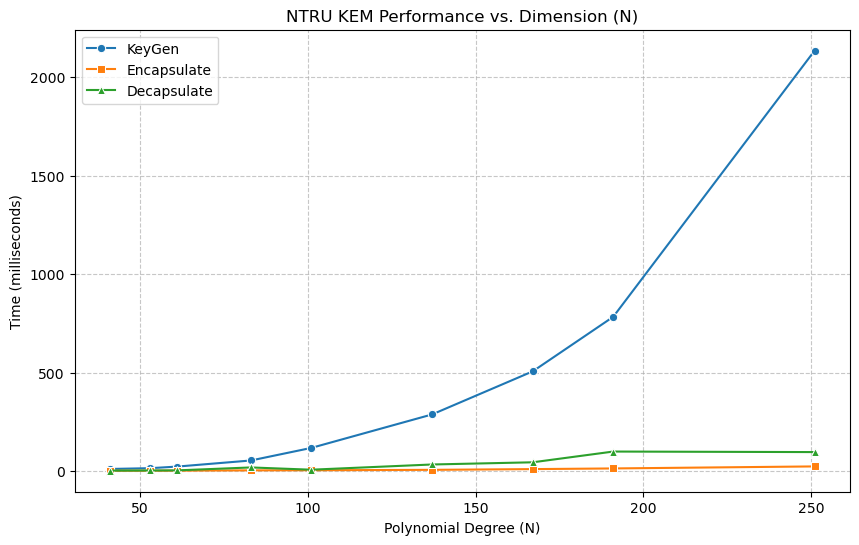


--- Raw Timing Data (ms) ---
     N  KeyGen (ms)  Encapsulate (ms)  Decapsulate (ms)
0   41    10.047793          1.100397          1.697612
1   53    14.003897          1.226473          2.283311
2   61    22.140408          1.568675          2.828479
3   83    53.132963          2.981043         17.758703
4  101   116.984510          3.468990          6.278467
5  137   287.033820          5.553842         32.771730
6  167   505.902529          9.301686         43.890476
7  191   783.087587         12.675619         98.487616
8  251  2134.765673         22.960329         95.781493


In [25]:
# ==========================================
# RUN & PLOT
# ==========================================

# Use Primes or odd numbers. 
# We can test larger N now because we aren't doing the slow LLL attack!
N_range = [41, 53, 61, 83, 101, 137, 167, 191, 251] 

df_timing = run_ntru_kem_timing(N_range, q_fixed=2048, trials=10)

if not df_timing.empty:
    plt.figure(figsize=(10, 6))
    
    # Plot 3 lines
    sns.lineplot(data=df_timing, x='N', y='KeyGen (ms)', marker='o', label='KeyGen')
    sns.lineplot(data=df_timing, x='N', y='Encapsulate (ms)', marker='s', label='Encapsulate')
    sns.lineplot(data=df_timing, x='N', y='Decapsulate (ms)', marker='^', label='Decapsulate')
    
    plt.title('NTRU KEM Performance vs. Dimension (N)')
    plt.xlabel('Polynomial Degree (N)')
    plt.ylabel('Time (milliseconds)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.show()
    
    print("\n--- Raw Timing Data (ms) ---")
    print(df_timing)


--- Benchmarking Key Sizes (Fixed q=2048) ---
N=19 : Priv=0.00 KB | Pub=0.02 KB
N=23 : Priv=0.00 KB | Pub=0.03 KB
N=31 : Priv=0.00 KB | Pub=0.04 KB
N=41 : Priv=0.01 KB | Pub=0.05 KB
N=47 : Priv=0.01 KB | Pub=0.06 KB
N=53 : Priv=0.01 KB | Pub=0.06 KB
N=61 : Priv=0.01 KB | Pub=0.07 KB
N=71 : Priv=0.01 KB | Pub=0.09 KB
N=83 : Priv=0.01 KB | Pub=0.10 KB
N=101: Priv=0.01 KB | Pub=0.12 KB
N=151: Priv=0.02 KB | Pub=0.19 KB


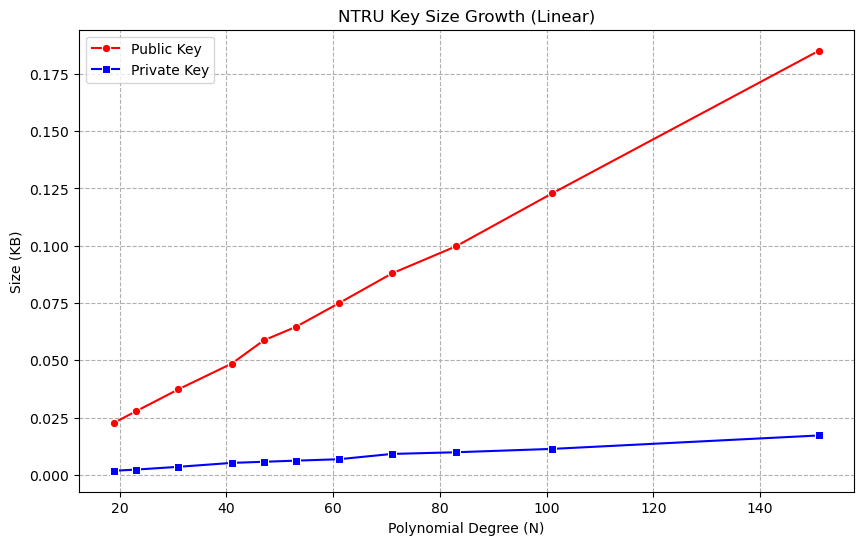

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sage.all import *

# ==========================================
# 1. ROBUST SIZE CALCULATOR
# ==========================================
def get_structure_bits(obj):
    """
    Recursively calculates the bit size of integers, vectors, 
    polynomials, or tuples/lists of them.
    """
    total_bits = 0
    
    # Case A: It's a single number
    if hasattr(obj, 'nbits'):
        return obj.nbits()
    if isinstance(obj, int):
        return obj.bit_length()
    
    # Case B: It's a Sage Vector/Polynomial
    if hasattr(obj, 'list'):
        for coef in obj.list():
            total_bits += get_structure_bits(coef)
        return total_bits

    # Case C: It's a Tuple or List
    if isinstance(obj, (list, tuple)):
        for item in obj:
            total_bits += get_structure_bits(item)
        return total_bits
    
    return 0

def get_size_kb(obj):
    bits = get_structure_bits(obj)
    return float((bits / 8) / 1024)

# ==========================================
# 2. KEY SIZE RUNNER (With Type Safety)
# ==========================================
def benchmark_ntru_keysizes(N_list, q_fixed=2048):
    results = []
    print(f"\n--- Benchmarking Key Sizes (Fixed q={q_fixed}) ---")
    
    for N_val in N_list:
        # CRITICAL FIX: Cast Sage Integer to Python int immediately
        N = int(N_val)
        
        d = int(N // 3)
        p = 3
        
        if 2*d >= N: 
            continue
            
        try:
            # Generate Keys
            priv, pub = generate_keypair(p, q_fixed, N, d)
            
            # Calculate sizes
            size_priv = get_size_kb(priv)
            size_pub = get_size_kb(pub)
            
            results.append({
                'N': N,  # Now a standard Python int
                'Private Key (KB)': size_priv,
                'Public Key (KB)': size_pub
            })
            print(f"N={N:<3}: Priv={size_priv:.2f} KB | Pub={size_pub:.2f} KB")
            
        except Exception as e:
            print(f"N={N:<3}: Failed - {e}")
            
    return pd.DataFrame(results)

# ==========================================
# 3. RUN & PLOT
# ==========================================
# Using Primes for N
N_keys = [19, 23, 31, 41, 47, 53, 61, 71, 83, 101, 151]

df_keys_ntru = benchmark_ntru_keysizes(N_keys, q_fixed=2048)

if not df_keys_ntru.empty:
    plt.figure(figsize=(10, 6))
    
    # Plot Public Key
    sns.lineplot(data=df_keys_ntru, x='N', y='Public Key (KB)', 
                 marker='o', label='Public Key', color='red')
    
    # Plot Private Key
    sns.lineplot(data=df_keys_ntru, x='N', y='Private Key (KB)', 
                 marker='s', label='Private Key', color='blue')
    
    plt.title('NTRU Key Size Growth (Linear)')
    plt.ylabel('Size (KB)')
    plt.xlabel('Polynomial Degree (N)')
    plt.grid(True, linestyle='--')
    plt.legend()
    plt.show()